# Gather insights from the experiments run on GCP

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from common.utils import check_missing_experiments, join_df
from common.metrics import *

## Define the TTA Formula 

In [ ]:
# Calculate time to accuracy for different accuracies
def tta_crossbow(acc:int, df: pd.DataFrame, acc_column='accuracy', time_column='epoch_duration'):
    """Computes the tta as in the crossbow paper
    where the tta is the median of the last 5 epochs"""

    res = []
    for _, row in df.iterrows():
        done = False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
            
            # if there are less than 5 elements behind, continue
            if idx < 4:
                continue
                
            # calculate the median of the next five elements
            if np.median(accuracy[idx - 4:idx+1]) >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res


def tta(acc:int, df:pd.DataFrame,  acc_column='accuracy', time_column='epoch_duration'):
    
    
    res = []
    for _, row in df.iterrows():
        done=False
        dur, accuracy = row[time_column], row[acc_column]
        
        for idx, (t, a) in enumerate(zip(dur, accuracy[:len(dur)])):
         
            if a >= acc:
                res.append(t)
                done = True
                break

        if not done:
            res.append(np.nan)

    return res
        

# KubeML Experiments

How to treat the kubeml experiments

### Load the train results

In [ ]:
df = join_df('./results/resnet/train')
df = df[df.default_parallelism > 1]

In [ ]:
df

In [ ]:
# get duplicated rows
df[df.duplicated(['hash'], keep=False)]

Define the extra variables

In [ ]:
# Set the acc to the final accuracy
df['acc'] = df.accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.epoch_duration.map(lambda t: t[-1])

# Set the parallelism to the first since it is constant
df.parallelism = df.parallelism.map(lambda l:l[0])

# change -1 to inf so the order is right in the plot
df.k = df.k.map(lambda val: float('inf') if val == -1 else val)

df['global_batch'] = df.batch_size * df.parallelism




In [ ]:
# compute the ttas
df['tta_69'] = tta(69, df)
df['tta_cross_69'] = tta_crossbow(69, df)

# compute the ttas
df['tta_67'] = tta(67, df)
df['tta_cross_67'] = tta_crossbow(67, df)

# compute the ttas
df['tta_70'] = tta(70, df)
df['tta_cross_70'] = tta_crossbow(70, df)

### For the metrics in resnet

In [ ]:
metrics = join_df('./results/resnet/metrics')
m = metrics.rename(columns={'exp_name':'id'})

### For the metrics in the lenet

The first replication does not have the proper format, so we need to reformat it and combine it with the train results

In [ ]:
metrics1 = join_df('./results/lenet/metrics/1/')
metrics2 = join_df('./results/lenet/metrics/2/')
metrics3 = join_df('./results/lenet/metrics/3/')

cpu = metrics1.groupby('exp_name')['cpu'].apply(list)
mem = metrics1.groupby('exp_name')['mem'].apply(list)
exps = metrics1.groupby('exp_name')['exp_name']

metrics1 = pd.DataFrame({
    'cpu':cpu,
    'mem':mem
})
metrics1['exp_name'] = metrics1.index

# concat all metrics and rename the exp_name as in the train
m = pd.concat([metrics1, metrics2, metrics3], ignore_index=True)
m.rename(columns={'exp_name':'id'}, inplace=True)


Now we need to add extra summary columns to the metrics

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

#### Combine and Save the whole experiment

In [ ]:
d = df.merge(m, on='id')
d.to_pickle('./dataframes/resnet_kubeml.pkl')


# TensorFlow Experiments

How to treat the TF experiments

In [ ]:
folder = 'resnet_new'
df = join_df(f'./results/tf/{folder}/train/1/', f'./results/tf/{folder}/train/2', f'./results/tf/{folder}/train/3')

# Set the acc to the final accuracy
df['acc'] = df.val_accuracy.map(lambda a: a[-1])

# Set the time to the sum of the epoch durations
df['time'] = df.times.map(lambda t: t[-1])



In [ ]:
# Define the TTA
df['tta_67'] = tta(0.67, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_67'] = tta_crossbow(0.67, df, time_column='times', acc_column='val_accuracy')

df['tta_69'] = tta(0.69, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_69'] = tta_crossbow(0.69, df, time_column='times', acc_column='val_accuracy')

df['tta_70'] = tta(0.70, df, time_column='times', acc_column='val_accuracy')
df['tta_cross_70'] = tta_crossbow(0.70, df, time_column='times', acc_column='val_accuracy')


## Merge the metrics from different  folders


In [ ]:
m = join_df(f'./results/tf/{folder}/metrics/1/', f'./results/tf/{folder}/metrics/2', f'./results/tf/{folder}/metrics/3')

In [ ]:
# functions to compute the mean of each and add columns
m['mem'] = m['mem'].map(lambda l: l[0] if isinstance(l[0], list) else l)
m['cpu'] = m['cpu'].map(lambda l: l[0] if isinstance(l[0], list) else l)

# cpu util
m['cpu_mean'] = m['cpu'].map(lambda l: np.mean([s.percent for s in l]))

# gpu mean mem and util
m['gpu_0_mean_usage'] = m['gpu_0'].map(lambda l: np.mean([s.load for s in l if s.mem_used != 0]) if not isinstance(l, float) else l)
m['gpu_1_mean_usage'] = m['gpu_1'].map(lambda l: np.mean([s.load for s in l if s.mem_used !=0]) if not isinstance(l, float) else l)
m['gpu_0_mean_memory'] = m['gpu_0'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_1_mean_memory'] = m['gpu_1'].map(lambda l: np.mean([s.mem_used for s in l if s.mem_used != 0])if not isinstance(l, float) else l)
m['gpu_usage'] = (m['gpu_0_mean_usage'] + m['gpu_1_mean_usage']) /2

# memory mean util
m['mem_mean'] = m['mem'].map(lambda l: np.mean([s.percent for s in l]))

Join on the index

In [ ]:
df = df.join(m)

Save the experiments

In [ ]:
df.to_pickle('./dataframes/resnet_new_tensorflow.pkl')

# Visualization of Results


Set the color palette

In [ ]:
green_red_palette = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
blue_yellow_palette=  ['#0077b6', '#d62828', '#f77f00', '#fcbf49', '#eae2b7']
cool_p = ['#f87575', '#ffa9a3', '#b9e6ff', '#5c95ff', '#7e6c6c']
wall_p = ['#e63946', '#f1faee', '#a8dadc', '#457b9d', '#1d3557']

sns.palplot(sns.color_palette(blue_yellow_palette))


sns.set_theme(style='whitegrid', palette=blue_yellow_palette, )
sns.set_context('talk')
# sns.set_palette(blue_yellow_palette)

# Read the experiments file

### Load all of the dataframes

In [ ]:
# load the tf experiments
resnet = pd.read_pickle('./dataframes/resnet_new_tensorflow.pkl')
lenet = pd.read_pickle('./dataframes/lenet_tensorflow.pkl')

lenet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
lenet['system'] = 'tensorflow'
lenet['acc'] = 100*lenet['acc']
lenet['accuracy'] = lenet['accuracy'].map(lambda l: [100*n for n in l])

# rename columns in the TF dataframes to adhere to the kubeml ones
resnet.rename(columns={
    'loss':'train_loss',
    'val_accuracy':'accuracy',
    'val_loss':'validation_loss',
    'times':'epoch_duration',
    'accuracy':'train_accuracy',
    'val_accuracy':'accuracy'
}, inplace=True)
resnet['system'] = 'tensorflow'
resnet['acc'] = 100*resnet['acc']
resnet['accuracy'] = resnet['accuracy'].map(lambda l: [100*n for n in l])


# set the columns of the 

# load the kubeml experiments
kuberesnet = pd.read_pickle('./dataframes/resnet_kubeml.pkl')
kuberesnet['model'] = 'resnet'
kuberesnet['system'] = 'kubeml'
# kuberesnet['tta_70'] = tta(70, kuberesnet)
# kuberesnet['tta_cross_70'] = tta_crossbow(70, kuberesnet)

kubelenet = pd.read_pickle('./dataframes/lenet_kubeml.pkl')
kubelenet['model'] = 'lenet'
kubelenet['system'] = 'kubeml'


In [ ]:
# save the full resnet stuff
r.to_pickle('./dataframes/resnet_new.pkl')

In [ ]:
r = pd.concat([resnet, kuberesnet], ignore_index=True)
r
# resnet

### Create new columns for representation

- Final accuracy
- Total time taken
- Parallelism

### Plot the Correlations between the K, Batch and Parallelism with time and accuracy

In [ ]:
corr = df[['k', 'batch_size', 'parallelism', 'acc', 'time']].corr()
sns.heatmap(corr,
            annot=True,
)

# plt.savefig('./figures/resnet34/heat.png', dpi=300)


In [ ]:
df.sort_values('time')

mean = df.groupby('hash').mean()

### Get the max accuracies and times and check the parameters used

In [ ]:
# get the max accuracies
df[['k', 'parallelism', 'acc','batch_size','time']].sort_values(by='time', ascending=True)

## Calculate TTA with different accuracies



In [ ]:
s = df.sort_values('tta_cross_99')[['k', 'batch_size', 'parallelism', 'tta_cross_99', 'tta_99', 'acc', 'accuracy', 'epoch_duration']]

# plot the best
best = s.iloc[0]
best


x = range(1, len(best.accuracy)+1)
plt.figure()
plt.title(f'Best tta_99 (B={best.batch_size}, k={best.k}, P={best.parallelism})')
sns.lineplot(x=best.epoch_duration, y = best.accuracy)
sns.lineplot(x=best.epoch_duration, y= 99)
plt.scatter(best.tta_cross_99, 99, marker='X', s=60, c='r')
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)

# plt.savefig('./figures/gpu/best.png', dpi=300)


# Plot the resnet results KubeML vs Tensorflow

In [ ]:
#Define the colors used
tf_color = '#FF6F00'
kubecolor = '#316CE6'



## LeNet Results

In [ ]:
l = pd.read_pickle('./dataframes/lenet.pkl')

### Plot the Accuracy and Train Loss Progression

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = l[l.system=='tensorflow']
ml = l[l.system =='kubeml']
sample = tf.iloc[5]
kubesample = ml.iloc[87]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([97, 100])
ax1.set_xlabel('Time (sec)')



# plot the line at 69%
sns.lineplot(x=kubesample.epoch_duration,
            y=99,
            ax=ax1,
            color='red')

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')

ax2.set_xlabel('Time (sec)')

### Plot the whole comparison

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


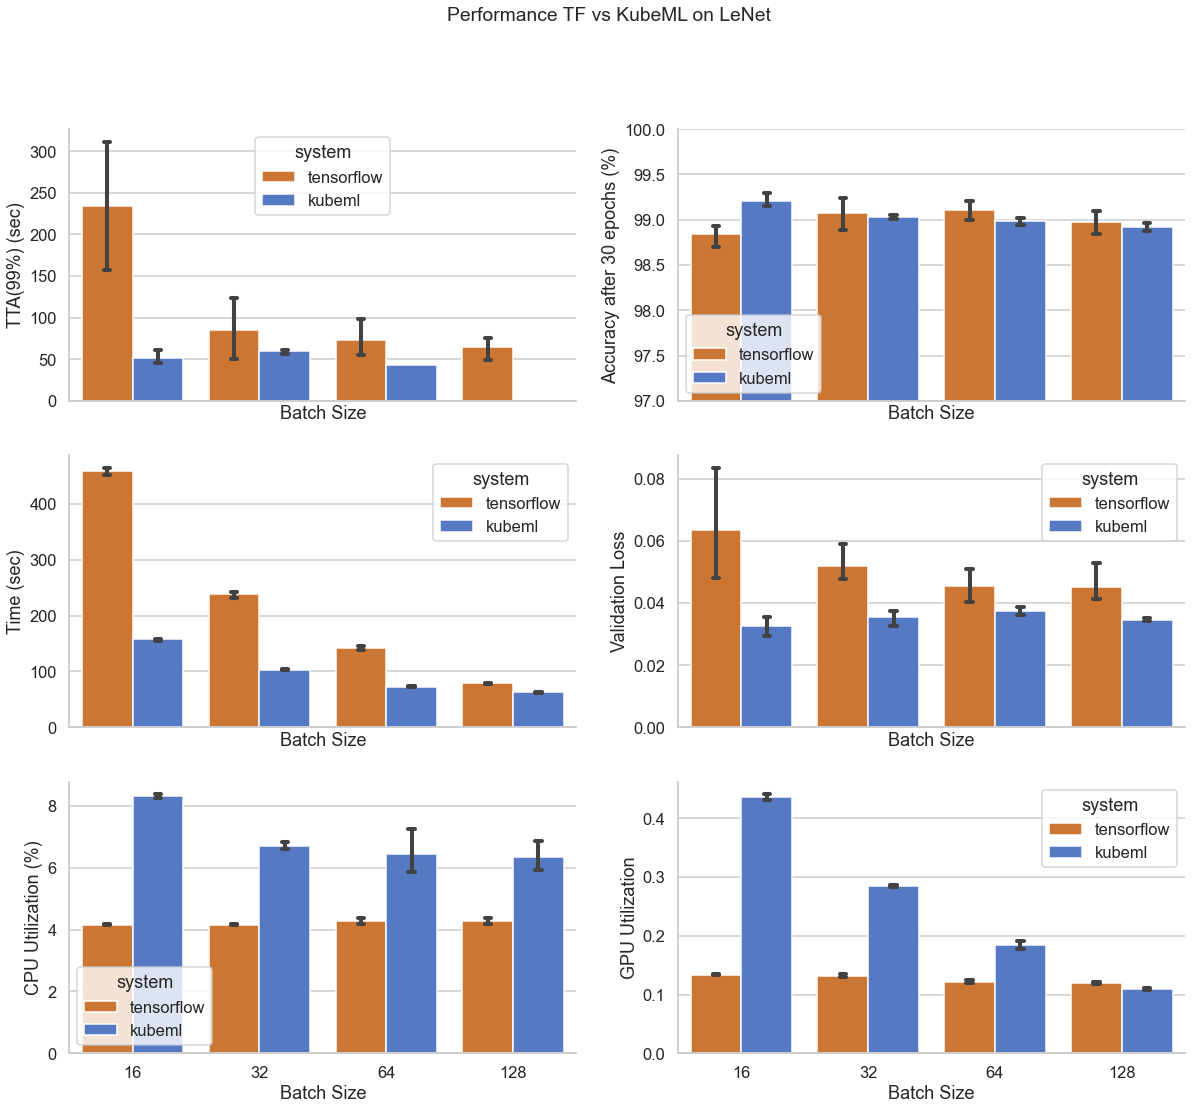

In [173]:
# get only the results with k=-1 and 
_l = l[((l.parallelism==4) | (l.parallelism.isna())) & ((l.k==float('inf')) | (l.k.isna())) ]

# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(3, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_99', 
            data=_l, 
            hue='system',
            capsize=.05,
            ax=ax[0][0])
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA(99%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[0][1])
ax[0][1].set_ylim([97, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
sns.barplot(x='batch_size', 
            y='time', 
            data=_l, 
            hue='system', 
            capsize=.05,
            ax=ax[1][0])
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Time (sec)')


# 4) Plot the val loss of both compared
# calculate the loss
_l['loss'] = _l['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[1][1])

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')

plt.suptitle('Performance TF vs KubeML on LeNet')


## Plot the difference in cpu and gpu utilization
# CPU util
sns.barplot(x='batch_size', 
            y='cpu_mean', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[2][0])

ax[2][0].set_xlabel('Batch Size')
ax[2][0].set_ylabel('CPU Utilization (%)')

# GPu Util
sns.barplot(x='batch_size', 
            y='gpu_usage', 
            data=_l ,
            capsize=.05,
            hue='system',
            ax=ax[2][1])

ax[2][1].set_xlabel('Batch Size')
ax[2][1].set_ylabel('GPU Utilization')


sns.despine()

# plt.savefig('./figures/ppt/lenet-performance.png', dpi=400)

### Comparison of accuracy and time between K

In [ ]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 10))



_kubelenet = l[(l.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='parallelism',
           ax=ax[0])
ax[0].set_xlabel('Batch Size')
ax[0].set_ylabel('Time (sec)')


_kubelenet = l[(l.system == 'kubeml') & (l.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kubelenet, 
           hue='k',
           ax=ax[1])
ax[1].set_xlabel('Batch Size')
ax[1].set_ylabel('Time (sec)')

plt.suptitle('Evolution of Time with Parallelism and K')

plt.savefig('./figures/ppt/lenet-time.png', dpi=400)

## Resnet Results

#### Plot the Train Loss and Val Accuracy of Tensorflow and KubeML


In [194]:
# set the palette
sns.set_palette([tf_color, kubecolor], desat=0.8)

In [ ]:
r = pd.read_pickle('./dataframes/resnet_new.pkl')

In [ ]:
r[(r.batch_size==32) & (r.system=='kubeml') & (r.k == float('inf')) & (r.parallelism ==4)].iloc[0].epoch_duration

<AxesSubplot:ylabel='train_loss'>

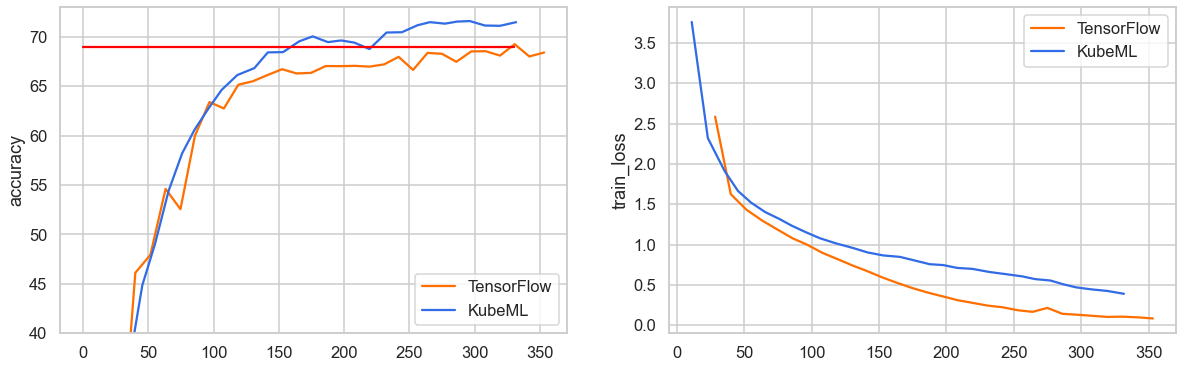

In [203]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 6))

# get the best results
tf = r[r.system=='tensorflow']
ml = r[r.system =='kubeml']
sample = r.iloc[2]
kubesample = r.iloc[61]

# sort for tta69 and show

# 1) plot the validation accuracy of TF
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.accuracy[:30],
             data=sample, 
            ax=ax1, 
            label='TensorFlow',
            color='#FF6F00')

# 2) plot the validation accuracy of KubeML
sns.lineplot(x=kubesample.epoch_duration,
             y='accuracy',
             data=kubesample, 
            ax=ax1, 
            label='KubeML',
            color='#316CE6')

ax1.set_ylim([40, 73])



# plot the line at 69%
sns.lineplot(x=range(int(kubesample.time)),
            y=69,
            ax=ax1,
            color='red')

ax1.s

# 3) Plot the train loss
sns.lineplot(x=sample.epoch_duration[:30],
             y=sample.train_loss[:30],
             data=sample, 
            ax=ax2, 
            label='TensorFlow',
            color='#FF6F00')

# 3) Plot the train loss
sns.lineplot(x=kubesample.epoch_duration,
             y='train_loss',
             data=kubesample, 
            ax=ax2, 
            label='KubeML',
            color='#316CE6')


### Plot the metrics of both 

c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

Text(0.5, 0.98, 'Performance TF vs KubeML on Resnet34')

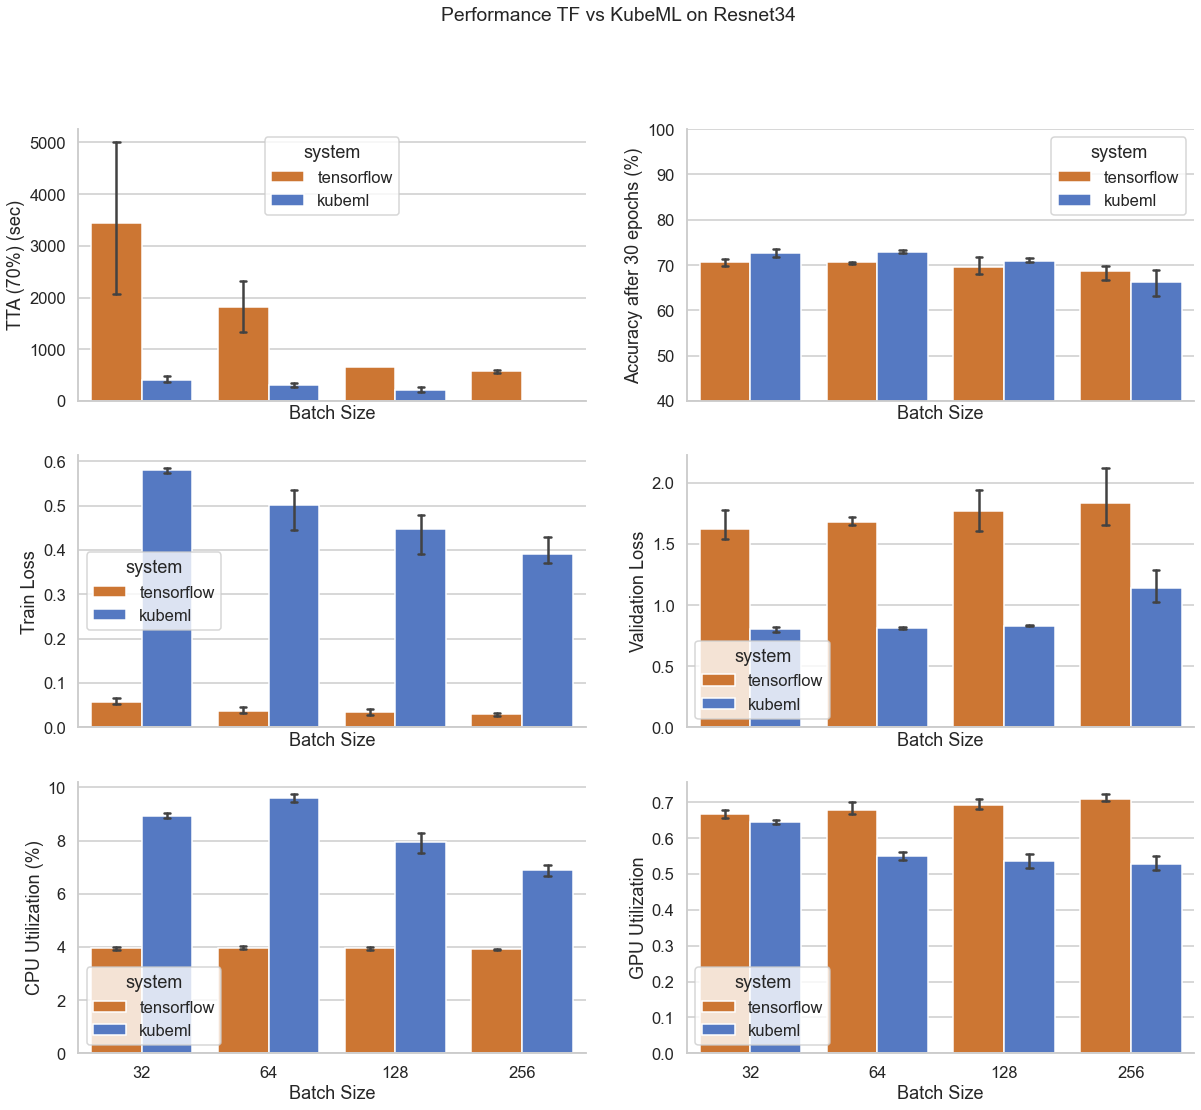

In [196]:
# get only the results with k=-1 and 
_r = r[((r.parallelism==4) | (r.parallelism.isna())) & ((r.k==float('inf')) | (r.k.isna())) ]
_r['t30'] = _r['time']


# COMPARE THE LOSSES, THE VAL LOSS OF KUBEML SHOULD BE HIGHER (DO NOT KNOW THE TRAIN LOSS, BECAUSE OF EXPLORATION,
# WHILE STILL GIVING BEST ACCURACY (BETTER GENERALIZATION))
f, ax = plt.subplots(3, 2, sharex=True, figsize=(20, 17))

# 1) Plot the comparison of tta between both
sns.barplot(x='batch_size', 
            y='tta_70', 
            data=_r, 
            hue='system', 
            errwidth=2.5,
            ax=ax[0][0],
           capsize=.05)
ax[0][0].set_xlabel('Batch Size')
ax[0][0].set_ylabel('TTA (70%) (sec)')


# 2) Plot the max accuracy
sns.barplot(x='batch_size', 
            y='acc', 
            data=_r, 
            hue='system', 
            errwidth=2.5,
            ax=ax[0][1],
            capsize=.05)
ax[0][1].set_ylim([40, 100])
ax[0][1].set_xlabel('Batch Size')
ax[0][1].set_ylabel('Accuracy after 30 epochs (%)')


# 3) Plot the difference in GPU utilzation
_r['t_loss'] = _r['train_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='t_loss', 
            data=_r, 
            hue='system',
            errwidth=2.5,
            ax=ax[1][0],
            capsize=.05,
               )
ax[1][0].set_xlabel('Batch Size')
ax[1][0].set_ylabel('Train Loss')


# 4) Plot the val loss of both compared
# calculate the loss
_r['loss'] = _r['validation_loss'].map(lambda l:l[-1])
sns.barplot(x='batch_size', 
            y='loss', 
            data=_r ,
            hue='system',
            errwidth=2.5,
            ax=ax[1][1],
            capsize=.05)

ax[1][1].set_xlabel('Batch Size')
ax[1][1].set_ylabel('Validation Loss')


## Plot the difference in cpu and gpu utilization
# CPU util
sns.barplot(x='batch_size', 
            y='cpu_mean', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
            ax=ax[2][0])

ax[2][0].set_xlabel('Batch Size')
ax[2][0].set_ylabel('CPU Utilization (%)')

# GPu Util
sns.barplot(x='batch_size', 
            y='gpu_usage', 
            data=_r ,
            capsize=.05,
            errwidth=2.5,
            hue='system',
            ax=ax[2][1])

ax[2][1].set_xlabel('Batch Size')
ax[2][1].set_ylabel('GPU Utilization')


sns.despine()
plt.suptitle('Performance TF vs KubeML on Resnet34')

# plt.savefig('./figures/ppt/resnet-performance.png', dpi=400)


### Comparison of Time with Parallelism and K

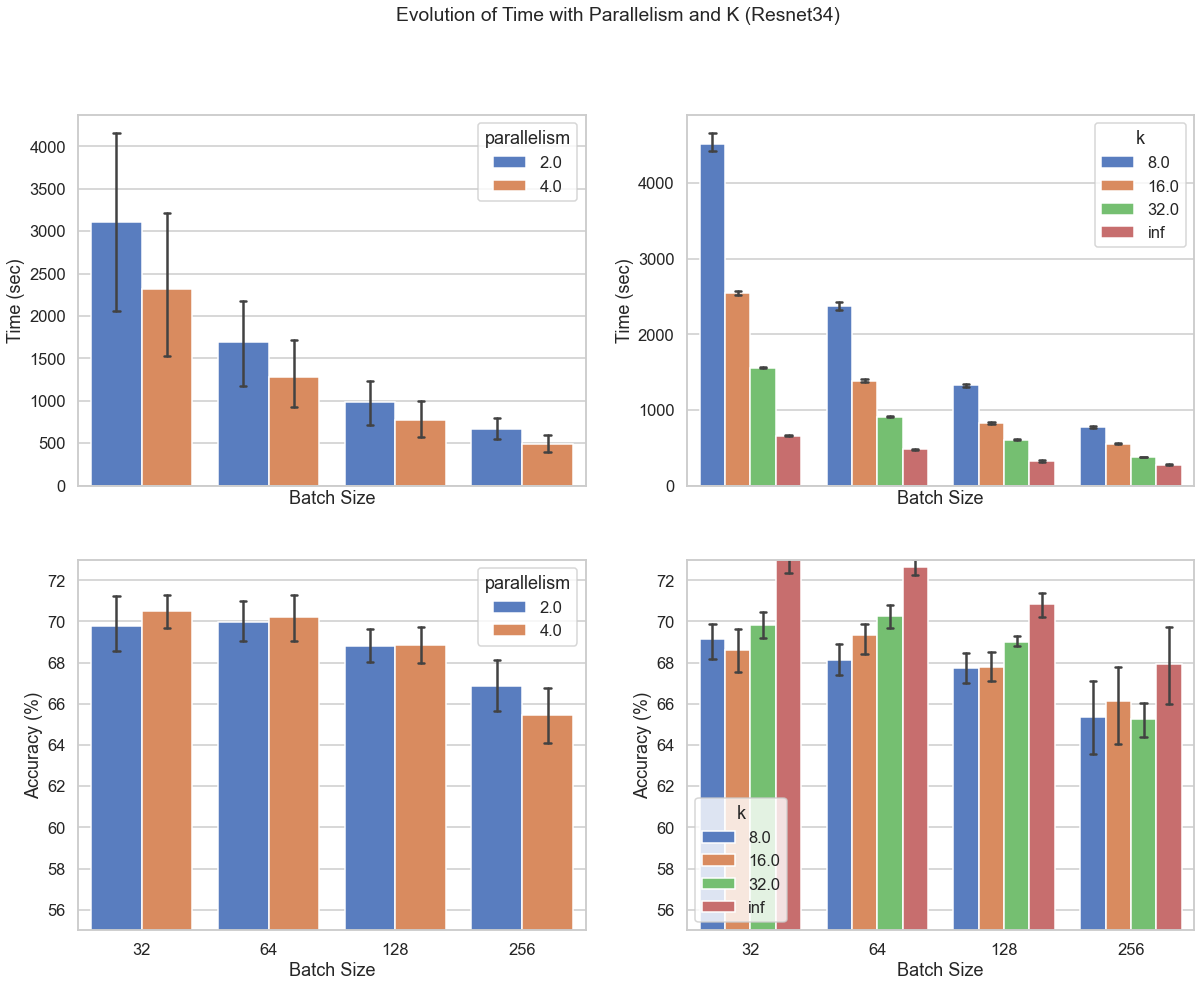

In [197]:
f, (ax1, ax2) = plt.subplots(2, 2, sharex=True, figsize=(20, 15))

sns.set_palette('muted',10)

_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            errwidth=2.5,
            capsize=.05,
           hue='parallelism',
           ax=ax1[0])
ax1[0].set_xlabel('Batch Size')
ax1[0].set_ylabel('Time (sec)')





_kuberesnet = r[(r.system == 'kubeml') & (r.parallelism==4)]
# 2) plot the time reached with different k
sns.barplot(x='batch_size',
           y='time',
           data=_kuberesnet, 
            capsize=.05,
           hue='k',
        errwidth=2.5,
           ax=ax1[1])
ax1[1].set_xlabel('Batch Size')
ax1[1].set_ylabel('Time (sec)')



_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='acc',
           data=_kuberesnet, 
           hue='parallelism',
            capsize=.05,
            errwidth=2.5,
           ax=ax2[0])
ax2[0].set_xlabel('Batch Size')
ax2[0].set_ylabel('Accuracy (%)')
ax2[0].set_ylim([55, 73])


_kuberesnet = r[(r.system == 'kubeml')]
# 1) plot the accuracy reached with different k
sns.barplot(x='batch_size',
           y='acc',
            errwidth=2.5,
            capsize=.05,
           data=_kuberesnet, 
           hue='k',
           ax=ax2[1])
ax2[1].set_xlabel('Batch Size')
ax2[1].set_ylabel('Accuracy (%)')
ax2[1].set_ylim([55, 73])

plt.suptitle('Evolution of Time with Parallelism and K (Resnet34)')

plt.savefig('./figures/ppt/resnet-time.png', dpi=400)

In [ ]:
g = _r.loc[(_r.batch_size==32) & (_r.system=='kubeml')]
for a, t in zip(g.iloc[0].accuracy, g.iloc[0].epoch_duration):
    print(t, a)

## Do ANOVA Linear Model to calculate the influence of the parameters

Using ANOVA we can get an idea of how the different parameters interact with each other and their influence

In [ ]:
# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the batch, k and parallelism columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ batch_size*k*parallelism', df).fit()
        
    else:
        if y not in ['acc', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(df.groupby(['batch_size', 'k', 'parallelism']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res, model

In [ ]:
# df.k = df.k.map(lambda val: -1 if val == float('inf') else val)

res, model = ANOVA(d, y='gpu_usage', verbose=True)

res

